In [ ]:
!pip install -q -U imgaug
!pip install -Uqq ipdb
import ipdb

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/fulldata.json      
  inflating: data/test.npy           
  inflating: data/train.npy          
  inflating: data/val.npy            


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as imgaugters

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 24 * 2 ## x and y for each keypoints as there are 24 keypoints in total

In [ ]:
IMAGE_DIR = "Images"
JSON = "data/fulldata.json"
KEYPOINT_DEF = ("keypoint_definitions.csv")

In [ ]:
with open(JSON) as inputfile:
  json_data = json.load(inputfile)

In [ ]:
jsondata_dict = {} 

In [ ]:
for i in json_data:
  jsondata_dict[i["img_path"]] = i

In [ ]:
for key,value in jsondata_dict.items():
  print(key,":")
  print(value)
  break;

n02085782-Japanese_spaniel/n02085782_2886.jpg :
{'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg', 'img_width': 350, 'img_height': 272, 'img_bbox': [205, 20, 116, 201], 'is_multiple_dogs': False, 'joints': [[108.66666666666667, 252.0, 1], [147.66666666666666, 229.0, 1], [163.5, 208.5, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [54.0, 244.0, 1], [77.33333333333333, 225.33333333333334, 1], [79.0, 196.5, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [150.66666666666666, 86.66666666666667, 1], [88.66666666666667, 73.0, 1], [116.0, 106.33333333333333, 1], [109.0, 123.33333333333333, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'seg': 'Yi71c01S74jHNU75gHMX75eHM[74cHM\\76`HL4HQ7k0lHXOT7R1O2N010O010jLiNROW1m0lNROT1m0oNPOQ1P1QOoNn0R1ROnNn0oMkNQ2:Nl0oMlNQ2:0j0nMnNP291j0mMoNR280j0kMPOLEg1c0`0i0lMCb1Db0i0jMGa1Ae0h0iMI`1_Og0j0fMK`1\\Oj0i0eMN^1ZOl0i0dM1]1WOm0k0cM2]1TOP1j0bM4\\1ROR1k0`M<W1iNX1l0`M=:ZN4=Q2T3aMXLO8>=Q2k3oMULQ2k3oMTLQ2m3mMULS2j3mMWLS2i3kMYLT2h

In [ ]:
### in jsondata_dict there is img_path and joints
## Each joints has 24 keypoints/single joint
## Based on the index of keypoint definitions dataframe 
##we can notice the description of each joint in joints of jsondata_dict
## for example 'joints': [[108.66666666666667, 252.0, 1], [147.66666666666666, 229.0, 1]....]
## the first value is Left front leg:paw and second is Left front leg: middle joint
keypoint_definitions = pd.read_csv(KEYPOINT_DEF)
keypoint_definitions##description about each keypoint, like name of keypoint, color information, animal pose name

Index                           Name  ... Animal-pose (name in animal pose)
0       0            Left front leg: paw  ...           y               L_F_Paw
1       1   Left front leg: middle joint  ...           y              L_F_Knee
2       2            Left front leg: top  ...           y             L_F_Elbow
3       3             Left rear leg: paw  ...           y               L_B_Paw
4       4    Left rear leg: middle joint  ...           y              L_B_Knee
5       5             Left rear leg: top  ...           y             L_B_Elbow
6       6           Right front leg: paw  ...           y               R_F_Paw
7       7  Right front leg: middle joint  ...           y              R_F_Knee
8       8           Right front leg: top  ...           y             R_F_Elbow
9       9            Right rear leg: paw  ...           y               R_B_Paw
10     10   Right rear leg: middle joint  ...           y              R_B_Knee
11     11            Right rear leg: top  ...           y             R_B_Elbow
12     12                     Tail start  ...           y              TailBase
13     13                       Tail end  ...           n                   NaN
14     14               Base of left ear  ...           y             L_EarBase
15     15              Base of right ear  ...           y             R_EarBase
16     16                           Nose  ...           y                  Nose
17     17                           Chin  ...           n                   NaN
18     18                   Left ear tip  ...           n                   NaN
19     19                  Right ear tip  ...           n                   NaN
20     20                       Left eye  ...           y                 L_Eye
21     21                      Right eye  ...           y                 R_Eye
22     22                        Withers  ...           y               Withers
23     23                         Throat  ...           y                Throat

[24 rows x 6 columns]

In [ ]:
colours = keypoint_definitions["Hex colour"].values.tolist()

In [ ]:
colours = ['#' + colour for colour in colours]

In [ ]:
colours

['#d82400',
 '#d82400',
 '#d82400',
 '#fcfc00',
 '#fcfc00',
 '#fcfc00',
 '#48b455',
 '#48b455',
 '#48b455',
 '#0090aa',
 '#0090aa',
 '#0090aa',
 '#d848ff',
 '#d848ff',
 '#fc90aa',
 '#006caa',
 '#d89000',
 '#d89000',
 '#fc90aa',
 '#006caa',
 '#ededed',
 '#ededed',
 '#a9d08e',
 '#a9d08e']

In [ ]:
labels = keypoint_definitions["Name"].values.tolist()

In [ ]:
labels

['Left front leg: paw',
 'Left front leg: middle joint',
 'Left front leg: top',
 'Left rear leg: paw',
 'Left rear leg: middle joint',
 'Left rear leg: top',
 'Right front leg: paw',
 'Right front leg: middle joint',
 'Right front leg: top',
 'Right rear leg: paw',
 'Right rear leg: middle joint',
 'Right rear leg: top',
 'Tail start',
 'Tail end',
 'Base of left ear',
 'Base of right ear',
 'Nose',
 'Chin',
 'Left ear tip',
 'Right ear tip',
 'Left eye',
 'Right eye',
 'Withers',
 'Throat']

In [ ]:
def read_img(name):
  data = jsondata_dict[name]
  img_data = plt.imread(os.path.join(IMAGE_DIR,data["img_path"]))
  if (img_data.shape[-1]) == 4:
    img_data = img_data.astype(np.uint8)
    img_data = Image.fromarray(img_data)
    img_data = np.array(img_data.convert("RGB"))
  data["img_data"] = img_data
  return data

In [ ]:
print(len(jsondata_dict.keys()))

12538


In [ ]:
sample = list(jsondata_dict.keys())
num_sample = 5
sample_data = np.random.choice(sample,5,replace=False)

In [ ]:
sample_data

array(['n02106382-Bouvier_des_Flandres/n02106382_3124.jpg',
       'n02095570-Lakeland_terrier/n02095570_3457.jpg',
       'n02113186-Cardigan/n02113186_2499.jpg',
       'n02091032-Italian_greyhound/n02091032_9592.jpg',
       'n02087394-Rhodesian_ridgeback/n02087394_9855.jpg'], dtype='<U60')

In [ ]:
imagearray_data = []
joints = []
for i in sample_data:
  data = read_img(i)
  imagearray_data.append(data["img_data"])
  joints.append(data["joints"])

{'img_path': 'n02106382-Bouvier_des_Flandres/n02106382_3124.jpg', 'img_width': 567, 'img_height': 467, 'img_bbox': [25, 15, 529, 430], 'is_multiple_dogs': False, 'joints': [[394.6666666666667, 398.6666666666667, 1], [406.5, 331.5, 1], [0, 0, 0], [104.66666666666667, 404.3333333333333, 1], [131.5, 351.0, 1], [0, 0, 0], [344.0, 416.6666666666667, 1], [336.5, 338.0, 1], [356.5, 245.5, 1], [61.666666666666664, 413.6666666666667, 1], [72.5, 342.5, 1], [107.5, 242.0, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [534.3333333333334, 92.33333333333333, 1], [515.0, 146.5, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'seg': 'bY;6=8T=LeB:X=JcB:Y=c0M3M3M3L5L7I4K4M3L4L4M2M6G:G8G5J6G;B=K5K4]NgKhH]4W7lK\\HY4b7]1O1O1XO`I[Ib6a6cI]I^6^6gIaIZ6^6hI`IY6`6hI]IZ6b6l000O100O1M3M3M2O2M2M4M2M4M3M2O2N1O2N1O2N2L4N1O2N2M3M3M3M3L4J6N2O100O100O10000O100O100O10O0O2N1O2O0O2O0O2O1N1F;M2N3N1N3N1O2M3O001N2O001O001O1N101O1O1N2N2O1N2N2N2N2N2O001M2M4O001O1O1O1O1O001O1O100O1O1O001O1O1O1O1O1O001O1O

[[394.6666666666667, 398.6666666666667, 1],
 [406.5, 331.5, 1],
 [0, 0, 0],
 [104.66666666666667, 404.3333333333333, 1],
 [131.5, 351.0, 1],
 [0, 0, 0],
 [344.0, 416.6666666666667, 1],
 [336.5, 338.0, 1],
 [356.5, 245.5, 1],
 [61.666666666666664, 413.6666666666667, 1],
 [72.5, 342.5, 1],
 [107.5, 242.0, 1],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [534.3333333333334, 92.33333333333333, 1],
 [515.0, 146.5, 1],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]

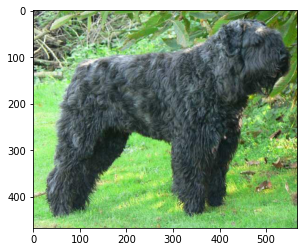

In [ ]:
plt.imshow(imagearray_data[0])
joints[0]

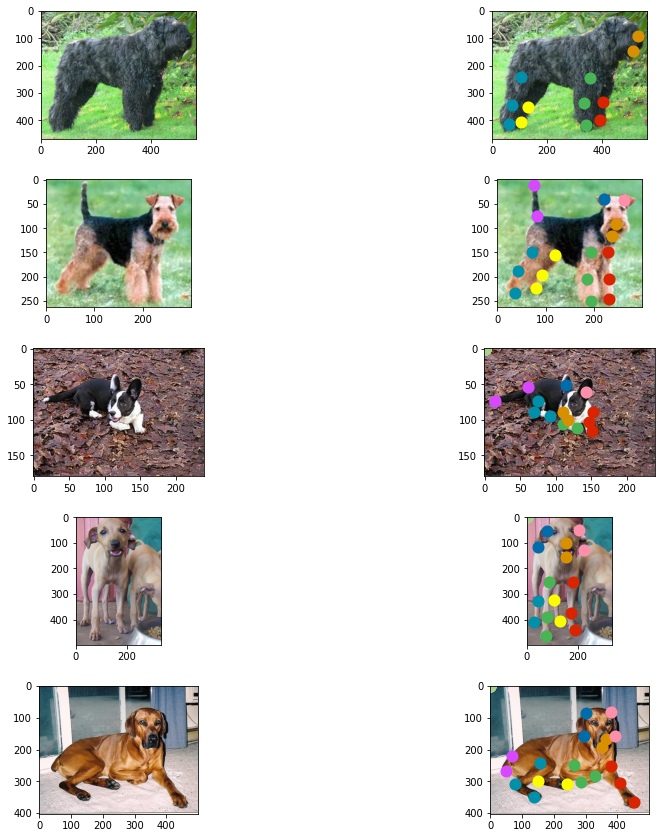

In [ ]:
def visualizedata(imagearraydata,keypointsjoints):
  fig, ax = plt.subplots(ncols=2,nrows=len(imagearraydata),figsize=(16,12))
  for (ax1,ax2), image, joint in zip(ax,imagearraydata,keypointsjoints):
    ax1.imshow(image)
    ax2.imshow(image)
    if isinstance(joint, KeypointsOnImage):
            for idx, kp in enumerate(joint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c=colours[idx], marker="x", s=50, linewidths=5
                )
    else:
      joint = np.array(joint)
      joint = joint[:,:2]
      for idx, (x, y) in enumerate(joint):
          ax2.scatter(x,y,c=colours[idx],marker='o',s=50, linewidths=5)
  plt.tight_layout(pad=2.0)
  plt.show()
visualizedata(imagearray_data,joints)

In [ ]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        print(self.indexes)
        print(self.image_keys)
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        print(self.indexes)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        print(indexes)
        image_keys_temp = [self.image_keys[k] for k in indexes]
        print(image_keys_temp)

        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), dtype="int")
        batch_keypoints = np.empty((self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32")

        for i, key in enumerate(image_keys_temp):
          data=read_img(key)
          keypoints=np.array(data['joints'])[:,:2]
          kp=[]

          for j in range(0,len(keypoints)):
              kp.append(Keypoint(keypoints[j][0],keypoints[j][1]))

          c_image = data["img_data"]
          kps_obj = KeypointsOnImage(kp,c_image)
          (new_image, new_kps_obj)=self.aug(image=c_image,keypoints=kps_obj)
          batch_images[i] = new_image
          k_temp=[]

          for keypoint in new_kps_obj:
            k_temp.append(np.nan_to_num(keypoint.x))
            k_temp.append(np.nan_to_num(keypoint.y))
          
          batch_keypoints[i] = np.array(k_temp).reshape(1, 1, 24 * 2)
        batch_keypoints = batch_keypoints / IMAGE_SIZE
        return (batch_images,batch_keypoints)

In [ ]:
train_aug = imgaugters.Sequential(
    [
        imgaugters.Resize(IMAGE_SIZE, interpolation="linear"),
        imgaugters.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        imgaugters.Sometimes(0.3, imgaugters.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = imgaugters.Sequential([imgaugters.Resize(IMAGE_SIZE, interpolation="linear")])

In [ ]:
train_image_keys, val_image_keys = (sample[:int(len(sample) * 0.80)],sample[int(len(sample) * 0.80):])

In [ ]:
print(len(train_image_keys))
print(len(val_image_keys))

10030
2508


[    0     1     2 ... 10027 10028 10029]
['n02085782-Japanese_spaniel/n02085782_2886.jpg', 'n02085782-Japanese_spaniel/n02085782_2914.jpg', 'n02085782-Japanese_spaniel/n02085782_2922.jpg', 'n02088238-basset/n02088238_9154.jpg', 'n02085782-Japanese_spaniel/n02085782_2978.jpg', 'n02088238-basset/n02088238_9162.jpg', 'n02091134-whippet/n02091134_20065.jpg', 'n02085782-Japanese_spaniel/n02085782_3019.jpg', 'n02088238-basset/n02088238_9267.jpg', 'n02085782-Japanese_spaniel/n02085782_3030.jpg', 'n02091134-whippet/n02091134_2193.jpg', 'n02085782-Japanese_spaniel/n02085782_3031.jpg', 'n02088238-basset/n02088238_9324.jpg', 'n02091134-whippet/n02091134_2235.jpg', 'n02085782-Japanese_spaniel/n02085782_3052.jpg', 'n02088238-basset/n02088238_9332.jpg', 'n02091134-whippet/n02091134_2339.jpg', 'n02085782-Japanese_spaniel/n02085782_3098.jpg', 'n02085782-Japanese_spaniel/n02085782_3121.jpg', 'n02091134-whippet/n02091134_2349.jpg', 'n02085782-Japanese_spaniel/n02085782_3148.jpg', 'n02088238-basset/n020

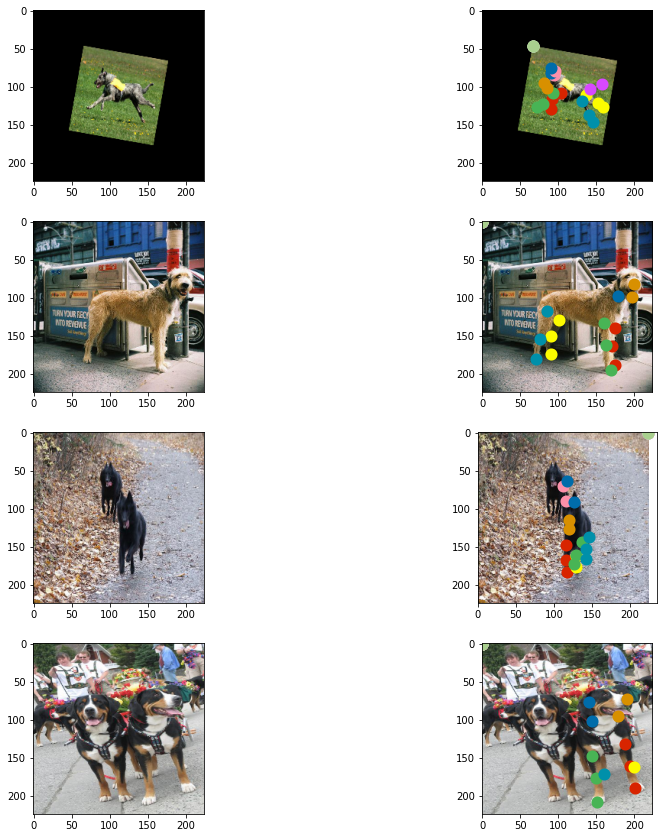

In [ ]:
train_dataset = KeyPointsDataset(train_image_keys, train_aug)
validation_dataset = KeyPointsDataset(val_image_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * IMAGE_SIZE
visualizedata(sample_images[:4], sample_keypoints)

In [ ]:
def get_model():
  # Load the pre-trained weights of Mobilenetv2
  backbone = keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),weights='imagenet',include_top=False)
  backbone.trainable=False
  inputs = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
  x = keras.applications.mobilenet_v2.preprocess_input(inputs)
  x = backbone(x)
  x = layers.Dropout(0.3)(x)
  x = layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu")(x)
  outputs = layers.SeparableConv2D(NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid")(x)

  return keras.Model(inputs, outputs, name="keypoint_detector")

In [ ]:
get_model().summary()

Model: "keypoint_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 3, 3, 48)          93488     
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 1, 1, 48)    

In [ ]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(train_dataset, validation_data=validation_dataset, epochs=EPOCHS)

Streaming output truncated to the last 5000 lines.
 4718 2876 3225 3110 3492 8078 3912 2264]
['n02086646-Blenheim_spaniel/n02086646_1825.jpg', 'n02087394-Rhodesian_ridgeback/n02087394_1099.jpg', 'n02090721-Irish_wolfhound/n02090721_1931.jpg', 'n02092002-Scottish_deerhound/n02092002_6503.jpg', 'n02085782-Japanese_spaniel/n02085782_385.jpg', 'n02086240-Shih-Tzu/n02086240_11551.jpg', 'n02102480-Sussex_spaniel/n02102480_2385.jpg', 'n02091244-Ibizan_hound/n02091244_2871.jpg', 'n02107683-Bernese_mountain_dog/n02107683_4558.jpg', 'n02085936-Maltese_dog/n02085936_3580.jpg', 'n02087394-Rhodesian_ridgeback/n02087394_3619.jpg', 'n02109961-Eskimo_dog/n02109961_9348.jpg', 'n02106166-Border_collie/n02106166_7074.jpg', 'n02108000-EntleBucher/n02108000_1194.jpg', 'n02095314-wire-haired_fox_terrier/n02095314_1894.jpg', 'n02093428-American_Staffordshire_terrier/n02093428_1925.jpg', 'n02088238-basset/n02088238_11281.jpg', 'n02108089-boxer/n02108089_11807.jpg', 'n02091134-whippet/n02091134_16109.jpg', 'n0

[   0    1    2 ... 2505 2506 2507]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
['n02090622-borzoi/n02090622_6131.jpg', 'n02090622-borzoi/n02090622_7960.jpg', 'n02090622-borzoi/n02090622_7961.jpg', 'n02090721-Irish_wolfhound/n02090721_1041.jpg', 'n02090721-Irish_wolfhound/n02090721_1774.jpg', 'n02090721-Irish_wolfhound/n02090721_2047.jpg', 'n02090721-Irish_wolfhound/n02090721_2964.jpg', 'n02090721-Irish_wolfhound/n02090721_3667.jpg', 'n02090721-Irish_wolfhound/n02090721_4362.jpg', 'n02090721-Irish_wolfhound/n02090721_448.jpg', 'n02090721-Irish_wolfhound/n02090721_6337.jpg', 'n02091032-Italian_greyhound/n02091032_1041.jpg', 'n02091032-Italian_greyhound/n02091032_1071.jpg', 'n02091032-Italian_greyhound/n02091032_1140.jpg', 'n02091032-Italian_greyhound/n02091032_12113.jpg', 'n02091032-Italian_greyhound/n02091032_1228.jpg', 'n02091032-Itali

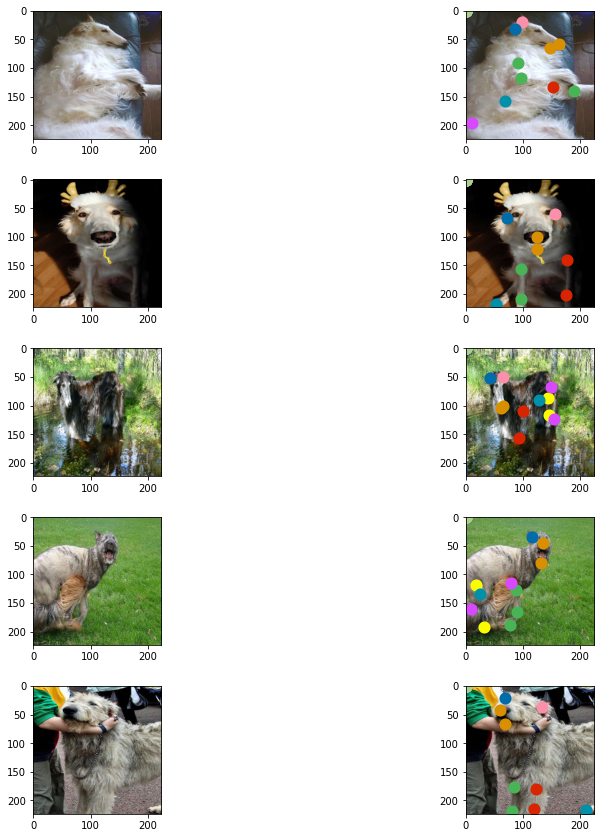

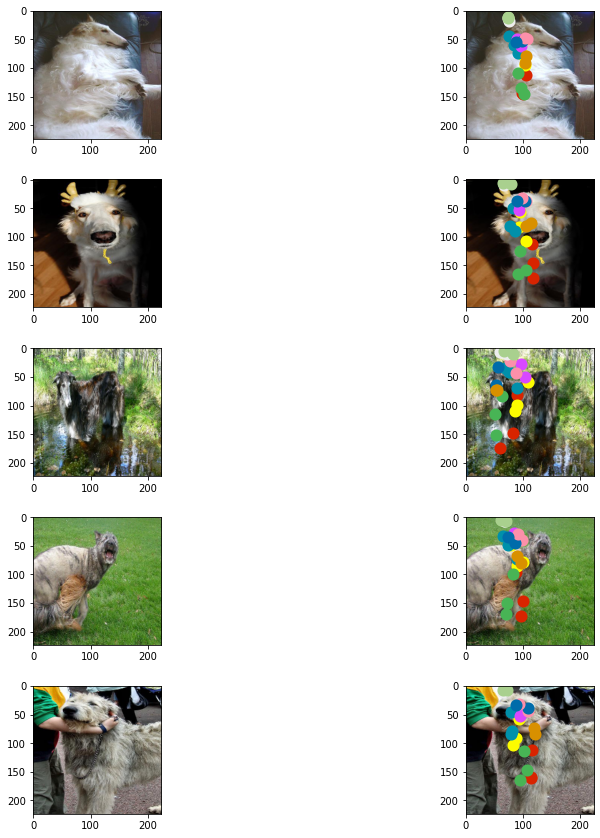

In [ ]:
sample_val_images, sample_val_keypoints = validation_dataset.__getitem__(index=0)
sample_val_images = sample_val_images[:5]
sample_val_keypoints = sample_val_keypoints[:5].reshape(-1, 24, 2) * IMAGE_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 24, 2) * IMAGE_SIZE

# Ground-truth
visualizedata(sample_val_images, sample_val_keypoints)

# Predictions
visualizedata(sample_val_images, predictions)

With further training this Keypoints detection model can be improved